In [1]:
#-*- coding: utf-8 -*-
import pickle
import os
import gc

def dec_to_hex(num):                                                                                                                           
    """ num : string                                                                                                                           
    range: 0x00-0x00ff                                                                                                                         
    """                                                                                                                                        
    t = int(num)                                                                                                                               
    assert 0x00ff, "out of range: " + str(t)                                                                                                   
    r = hex(t)                                                                                                                                 
    result = None                                                                                                                              
    if t > 0x000f:                                                                                                                             
        result = '0x00' +r[-2:]                                                                                                                
    else:                                                                                                                                      
        result = '0x000' +r[-1]                                                                                                                
    return result                                                                                                                              
                                                                                                                                               
def get_task_id(task_path):                                                                                                                    
    global task_line                                                                                                                           
    with open(task_path) as f:                                                                                                                 
        line = f.readlines()                                                                                                                   
                                                                                                                                               
    task_line = filter(lambda e: '__runTask()' in e , line)                                                                                    
    tasks_name = list()                                                                                                                        
                                                                                                                                               
    for e in task_line:                                                                                                                        
        if '/*' not in e and e not in tasks_name:                                                                                              
            tasks_name.append(e.strip())                                                                                                       
        elif '/*' in e:                                                                                                                        
            tasks_name.append(e[e.index('*/')+2:].strip())                                                                                     
                                                                                                                                               
    temp_tasks_name = list(map(lambda x: x[:-12], tasks_name))                                                                                 
    temp_tasks_id = list() #用于存放含有对任务名定义的行                                                                                       
    temp_list = list() #存放分割后的 temp_tasks_id                                                                                             
    temp_task_define = list() ##用于仅仅存放含有对任务名定义的行                                                                               
    task_id_temp = list()                                                                                                                      
    task_id = list()                                                                                                                           
                                                                                                                                               
    for e in temp_tasks_name:                                                                                                                  
        for i in line:                                                                                                                         
            if e in i and ' = ' in i and 'U' in i:                                                                                             
                temp_tasks_id.append(i.strip())                                                                                                
                                                                                                                                               
    for e in temp_tasks_id:                                                                                                                    
        temp_list.append(e.split(' '))                                                                                                         
    #map(lambda e: temp_list.append(e.split(' ')), temp_tasks_id) # do not work in python3                                                     
    for e in temp_tasks_name:                                                                                                                  
        for i in temp_list:                                                                                                                    
            if e == i[0] and i not in temp_task_define:                                                                                        
                temp_task_define.append(i)                                                                                                     
                                                                                                                                               
    for e in temp_task_define: task_id_temp.append((e[0], e[-1][:-1]))                                                                         
    #map(lambda e: task_id_temp.append((e[0], e[-1][:-1])), temp_task_define)    # do not work in python3                                      
                                                                                                                                               
    for e in task_id_temp: task_id.append((e[0], dec_to_hex(e[1])))                                                                            
    #map(lambda e: task_id.append((e[0], dec_to_hex(e[1]))), task_id_temp)# do not work in python3   
                                                                                                                                               
    return len(task_id_temp), task_id, task_id_temp # 分别以十六进制和十进制表示  

def handle_capacity(ls, num = 1, unit='minute'):
    ''' 计算任务吞吐量
        Args:
         ls: list, logs look [(timestamp, taskid) ...]
         num: unit*num为计算机吞吐量的单位， 如 num = 1, unit = 'minute', 则表示单位为1分钟，
         unit: 基本单位，与num相乘为计算机吞吐量的基本的单位
        Retval:
    '''
    m = num*{'minute': 1000.0*60, 'hour': 1000.0*60*60, 'second':1000.0}[unit]
    diff_v = (ls[-1][0] - ls[0][0]) / (num*m)
    return int(round(len(ls)/diff_v, 0))

def wc(fn):
    """ the same as `wc -l fn` on linux 
    """
    with open(fn,'rb') as f:
        count = 0
        last_data = '\n'
        while True:
            data = f.read(0x400000)
            if not data:
                break
            count += data.count(b'\n')
            last_data = data
        if last_data[-1:] != b'\n':
            count += 1 # Remove this if a wc-like count is needed
    return count


def containlogfile(folder):
    ''' Does the folder contain log file?
    Args:
        folder: str
    '''
    
    for e in os.listdir(folder):
        if '.pkl' in e:
            return True        
    return False

data_path = '../TinyOS-Benchmark/preprocessed-dataset/'
paths_data = {}
paths = list(os.walk(data_path))
app_c_lines = {}
tasks_scale = {} # 每个应用内，每个任务的规模（代码行数）
task_id_name = {} # 每个应用的任务名字，id
data_handle_capacity = {}
for i in range(len(paths)):
    #if i > 8: break
    print('\n{:2}/{:2}: {}'.format(i, len(paths)-1, paths[i][0]))
    if containlogfile(paths[i][0]) and paths[i][0] not in paths_data:
        app_c = paths[i][0].replace('preprocessed-dataset', 'app.c') + '/app.c'
        tasks_scale_csv = paths[i][0].replace('preprocessed-dataset', 'app.c') + '/task_scale.csv'
        if os.path.isfile(app_c):
            temp_task_id_name = get_task_id(app_c)
            task_num = temp_task_id_name[0] # 获得任务数量
            task_id_name[paths[i][0]] = temp_task_id_name[1]
            if task_num < 10: # 少于10个任务的就不统计了
                print(' :)') # 为了换行
                continue  
            app_c_lines[paths[i][0]] = task_num
            # read csv
            with open(tasks_scale_csv, 'r') as f:
                temp = f.readlines()
                temp = map(lambda e: e.split(','), temp)
                temp = map(lambda e: (e[0], int(e[1])), temp)
                tasks_scale[paths[i][0]] = dict(temp)
            print(' lines: {},\ttasks num: {}'.format(wc(app_c), task_num), end='')
        else:
            print(' lines: no app.c')
            continue
            
        paths_data[paths[i][0]] = []
        diff_v = [] # 计算机吞吐量
        for e2 in paths[i][2]:
            fn = os.path.join(paths[i][0], e2)
            
            with open(fn, 'rb') as f:
                fn_list = pickle.load(f) # 读取log数据
                paths_data[paths[i][0]] += fn_list
                #print(fn_list[:10])
                diff_v.append(handle_capacity(fn_list, num = 1, unit='minute'))
        data_handle_capacity[paths[i][0]] = int(round(sum(diff_v)/len(diff_v), 0)) # 计算吞吐量
        print(' log items: {}\t'.format(len(paths_data[paths[i][0]])), end='')
    print(' :)')
task_id_namedict = {}# 改一下格式，改成{'app name': {"0x0021": "Adc__xxxx__sdddd", ....} ...}  
for k, v in task_id_name.items():
    temp = {}
    for e in v:
        temp[e[1]] = e[0]
    task_id_namedict[k] = temp
#{k: {e[1]:e[0] for e in v} for k, v in task_id_name }   






 0/49: ../TinyOS-Benchmark/preprocessed-dataset/
 :)

 1/49: ../TinyOS-Benchmark/preprocessed-dataset/RadioSenseToLeds
 lines: 27174,	tasks num: 20 log items: 750587	 :)

 2/49: ../TinyOS-Benchmark/preprocessed-dataset/TCPEcho
 lines: 33683,	tasks num: 23 log items: 371940	 :)

 3/49: ../TinyOS-Benchmark/preprocessed-dataset/MultihopOscilloscope
 lines: 42021,	tasks num: 40 log items: 384617	 :)

 4/49: ../TinyOS-Benchmark/preprocessed-dataset/tests
 :)

 5/49: ../TinyOS-Benchmark/preprocessed-dataset/tests/TestLpl
 lines: no app.c

 6/49: ../TinyOS-Benchmark/preprocessed-dataset/tests/RadioStress
 lines: 21176,	tasks num: 15 log items: 402764	 :)

 7/49: ../TinyOS-Benchmark/preprocessed-dataset/tests/TestLed
 :)

 8/49: ../TinyOS-Benchmark/preprocessed-dataset/tests/TestLed/MultiLedSingle
 :)

 9/49: ../TinyOS-Benchmark/preprocessed-dataset/tests/TestLed/BlinkLed
 :)

10/49: ../TinyOS-Benchmark/preprocessed-dataset/tests/TestLed/MultiLed
 :)

11/49: ../TinyOS-Benchmark/preprocessed-d

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np



def most_tasks(ls, num=5):
    ''' shoot tasks make up the majority in the logs
    Args:
        ls: list, logs look [(timestamp, taskid) ...]
        num: int, the top of task
    Retval:
        ([(taskid, number, precent) ... num], allprecent, num)
        allprecent is the sum of each prcent in the first item precents  
        num is the number of tasks, len(ls) yet.
    '''
    count = {}
    for e in ls:
        if e[1] in count:
            count[e[1]] += 1
        else:
            count[e[1]] = 1

    count = list(map(lambda k: (k, count[k]), count.keys()))
    count = sorted(count, key=lambda e: e[1], reverse=True)
    #count = list(map(lambda e: (e[0], e[1],  # using round to calculate the precent of tasks
    #                 round(float(e[1]) / len(ls), 2)), count))
    # no round() function
    count = list(map(lambda e: (e[0], e[1], 
                    float(e[1]) / len(ls)), count))    
    return count[:num], sum(map(lambda e: e[2], count[:num])), len(ls)

    

for k, v in app_c_lines.items():
    print(k, v)
plt.figure(0)

colors = ['r','g','m', 'y','k','orangered','darkorange', 'forestgreen', 'cornflowerblue', 'goldenrod',  'lawngreen', 'hotpink']
marks = ['<','*','h','v','o','>',',','H','+','x','D','d']
plt.rcParams['figure.figsize'] = (14.0, 10.0) # 设置figure_size尺寸

top_task_precent = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#top_task_precent = [0.2]
for i, precent in enumerate(top_task_precent):
    print(i, '\t', precent)
    y = []
    for k, v in paths_data.items():
        temp_toptask_num = int(round(app_c_lines[k]*precent, 0))
        retval = most_tasks(v, temp_toptask_num)
    #     for e in map(lambda e: e[2], retval[0]):
    #         plt.plot([idx], [e], marker='o', color='r')
        y.append(sum(map(lambda e: e[2], retval[0])))
    # 
    plt.plot(list(range(1, len(y) + 1)), y, marker=marks[i], linestyle='-', color=colors[i], lw=3.0, ms=10, label=str(precent*100)+'%')

        
plt.legend(loc = 'best')
plt.title("{} TinyOS Apps in Official Repository".format(len(app_c_lines.items()))) 
plt.ylim(0, 1)
plt.yticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [str(i*100)+'%' for i in top_task_precent])

app_xticks = []
for k, v in app_c_lines.items():
    if '/test/' in k: app_xticks.append(k[k.index('tests/')+len('tests/'):]) # tests目录下的app, 名字不包含tests
    else: app_xticks.append(k[k.index('preprocessed-dataset/')+len('preprocessed-dataset/'):])

plt.xticks(list(range(1, len(y) + 1)), app_xticks)
plt.setp(plt.gca().get_xticklabels(), rotation=-25, horizontalalignment='left')
plt.savefig('feature-by-frequency-2d.png')
plt.show()  
plt.close(0)    

../TinyOS-Benchmark/preprocessed-dataset/RadioSenseToLeds 20
../TinyOS-Benchmark/preprocessed-dataset/TCPEcho 23
../TinyOS-Benchmark/preprocessed-dataset/MultihopOscilloscope 40
../TinyOS-Benchmark/preprocessed-dataset/tests/RadioStress 15
../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420/TestAcks 15
../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420/LplBroadcastCountToLeds 21
../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420/LplUnicastPeriodicDelivery 22
../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420/RssiToSerial 21
../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420/TestPacketLink 26
../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420/TxThroughput 25
../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420/LplBroadcastPeriodicDelivery 22
../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420/TestSecurity/RadioCountToLeds1 19
../TinyOS-Benchmark/preprocessed-dataset/tests/TestEui 12
../TinyOS-Benchmark/preprocessed-dataset/tests/TestNetwork 36
../TinyOS-Benchmark/pre

<Figure size 640x480 with 1 Axes>

../TinyOS-Benchmark/preprocessed-dataset/RadioSenseToLeds 20
../TinyOS-Benchmark/preprocessed-dataset/TCPEcho 23
../TinyOS-Benchmark/preprocessed-dataset/MultihopOscilloscope 40
../TinyOS-Benchmark/preprocessed-dataset/tests/RadioStress 15
../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420/TestAcks 15
../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420/LplBroadcastCountToLeds 21
../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420/LplUnicastPeriodicDelivery 22
../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420/RssiToSerial 21
../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420/TestPacketLink 26
../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420/TxThroughput 25
../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420/LplBroadcastPeriodicDelivery 22
../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420/TestSecurity/RadioCountToLeds1 19
../TinyOS-Benchmark/preprocessed-dataset/tests/TestEui 12
../TinyOS-Benchmark/preprocessed-dataset/tests/TestNetwork 36
../TinyOS-Benchmark/pre



progressing --------------  13 ../TinyOS-Benchmark/preprocessed-dataset/tests/TestNetwork code lines: 36 	 handling cap:  22354
SerialP__RunTx__runTask 	 26.19%
UARTDebugSenderP__sendTask__runTask 	 14.73%
SerialDispatcherP__0__signalSendDone__runTask 	 13.09%
VirtualizeTimerC__0__updateFromTimer__runTask 	 12.6%
CC2420ReceiveP__receiveDone_task__runTask 	 11.48%
AlarmToTimerC__0__fired__runTask 	 6.16%
top 80% scale:  15832  num of tasks with top 80% 6 	actually value: 84.25 %
[('0x001c', 0.26189549276485696), ('0x0023', 0.14734977910480965), ('0x0020', 0.13094513943683023), ('0x000b', 0.1260145363286559), ('0x0009', 0.1147977184012124), ('0x000a', 0.06161255226925925)]


progressing --------------  14 ../TinyOS-Benchmark/preprocessed-dataset/tests/TestFtsp/Ftsp code lines: 16 	 handling cap:  159
CC2420ReceiveP__receiveDone_task__runTask 	 24.98%
TimeSyncP__0__processMsg__runTask 	 24.97%
VirtualizeTimerC__0__updateFromTimer__runTask 	 12.52%
AlarmToTimerC__0__fired__runTask 	 12.5

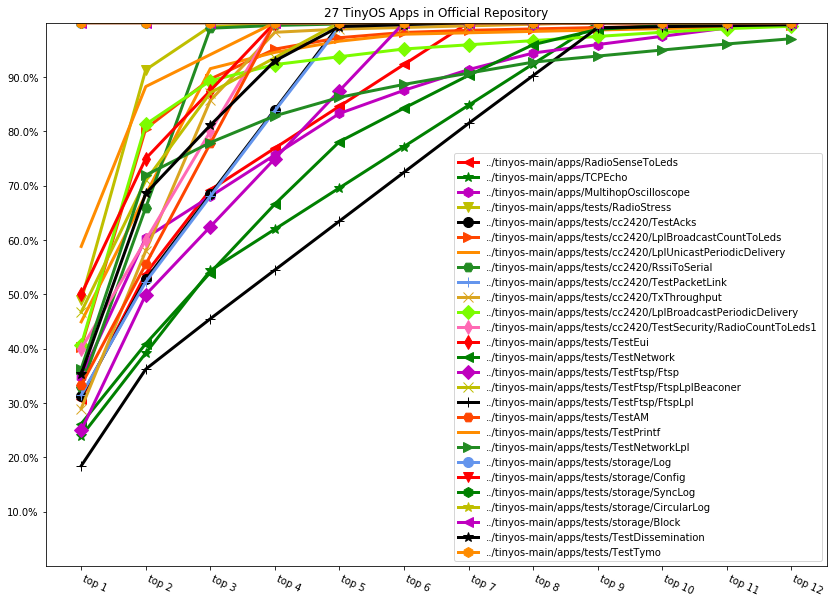

In [6]:
########### 不归一化 #####################
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

for k, v in app_c_lines.items():
    print(k, v)
    
    
def is_80precent(most):
    """ most的类型是most_tasks函数的返回值类型, 够80%,则该函数返回这占据了80%的任务id列表，否则返回None
    ([('0x0004', 230951, 0.30769384495068525), ('0x0003', 173210, 0.23076605376858378)], 0.538459898719269, 750587)
    """
    temp_sum = sum(map(lambda e: e[2] ,most[0]))
    if temp_sum >= 0.8:
        return list(map(lambda e: (e[0], e[2]) ,most[0])), most[1]
    
    
    

plt.figure(0)

colors = ['r','g','m', 'y','k','orangered','darkorange', 'forestgreen', 'cornflowerblue', 
          'goldenrod',  'lawngreen', 'hotpink','r','g','m', 'y','k','orangered','darkorange', 'forestgreen', 'cornflowerblue',
         'r','g','y','m', 'k','darkorange', 'orangered','forestgreen', 'cornflowerblue',]
marks = ['<','*','h','v','o','>',',','H','+','x','D','d', 
         'd', '<', 'D', 'x', '+', 'H', ',', '>', 'o', 'v', 'h', '*',
        '<','*','h','v','o','>',',','H','+','x','D','d', ]
plt.rcParams['figure.figsize'] = (14.0, 10.0) # 设置figure_size尺寸

top_task_precent = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
top_task_precent = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]



#top_task_precent = [0.2]
xls = {}
for i, k in enumerate(paths_data):
    y = []
    print('\n\nprogressing -------------- ', i, k, 'code lines:', app_c_lines[k],'\t handling cap: ', data_handle_capacity[k])
    reach_80_flag = False
    #scale_80 = 0
    for precent in top_task_precent:                  
        #temp_toptask_num = int(round(app_c_lines[k]*precent, 0))
        temp_toptask_num = precent
        retval = most_tasks(paths_data[k], temp_toptask_num)
        most_80 = is_80precent(retval)
        
        if not reach_80_flag and most_80 and most_80[1] >= 0.8:
            reach_80_flag = True
            #print(most_80)
            #print('debug ', task_id_namedict[k])
            scale_80 = 0
            sum80_precent = 0
            xls[k] = []
            for e in most_80[0]:
                #print('debug: ',tasks_scale[k])
                #print(k)
                scale_80 = scale_80 + tasks_scale[k][task_id_namedict[k][e[0]]+'__runTask']
                round_temp = round(e[1], 4)
                sum80_precent += round_temp
                xls[k].append((task_id_namedict[k][e[0]]+'__runTask', str(round(round_temp*100, 2))+'%'))
                
                print(task_id_namedict[k][e[0]]+'__runTask', '\t', str(round(round_temp*100, 2))+'%')
            xls[k].append(('total ',str(round(sum80_precent*100, 2))+'%'))
            print('top 80% scale: ', scale_80, ' num of tasks with top 80%', len(most_80[0]), '\tactually value:', str(round(sum80_precent*100, 2)),'%')
            print(most_80[0])
                #print("{}: {}".format(e, task_id_namedict[k][e]), end=", ")
        y.append(sum(map(lambda e: e[2], retval[0])))
    label = k[k.index('tests/')+len('tests/'):] if '/test/' in k else k[k.index('preprocessed-dataset/')+len('preprocessed-dataset/'):]
    #plt.plot(list(range(1, len(y) + 1)), y, marker=marks[i], linestyle='-', color=colors[i], lw=3.0, ms=10, label=label)
    plt.plot(list(range(1, len(y) + 1)), y, marker=marks[i], linestyle='-', color=colors[i], lw=3.0, ms=10, label=k.replace('TinyOS-Benchmark/preprocessed-dataset', 'tinyos-main/apps'))

        
plt.legend(loc = 'best')
plt.title("{} TinyOS Apps in Official Repository".format(len(app_c_lines.items()))) 
plt.ylim(0, 1)
plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [str(i*10.0)+'%' for i in range(1, 10)])
plt.xticks(top_task_precent, ['top '+str(i*100) for i in top_task_precent])

# app_xticks = []
# for k, v in app_c_lines.items():
#     if '/test/' in k: app_xticks.append(k[k.index('tests/')+len('tests/'):]) # tests目录下的app, 名字不包含tests
#     else: app_xticks.append(k[k.index('preprocessed-dataset/')+len('preprocessed-dataset/'):])

plt.xticks(list(range(1, len(top_task_precent) + 1)), ['top '+str(i) for i in top_task_precent])
plt.setp(plt.gca().get_xticklabels(), rotation=-25, horizontalalignment='left')
plt.savefig('feature-by-frequency-2d.png')
plt.show()  
plt.close(0)    

In [12]:
print(xls)

import xlwt  
import xlrd  
try:  
    # 创建excel文件  
    filename=xlwt.Workbook()  

    # 给工作表命名，test  
    sheet=filename.add_sheet("tab1")  
    # 写入内容，第4行第3列写入‘张三丰’  
    for i, k in enumerate(xls):
        sheet.write(i*2, 0, k[k.index('/tests/')+len('/tests/'):] if '/test/' in k else k[k.index('preprocessed-dataset/')+len('preprocessed-dataset/'):])
        for j, v in enumerate(xls[k]):
            sheet.write(i*2, j+1, v[0])
            sheet.write(i*2+1, j+1, v[1])
            
    # 指定存储路径，如果当前路径存在同名文件，会覆盖掉同名文件  
    filename.save("./tables1.xls")  

except Exception as e:  
    print(str(e))  
finally:
    print('Over ...')

{'../TinyOS-Benchmark/preprocessed-dataset/RadioSenseToLeds': [('VirtualizeTimerC__0__updateFromTimer__runTask', '30.77%'), ('AlarmToTimerC__0__fired__runTask', '23.08%'), ('CC2420ReceiveP__receiveDone_task__runTask', '15.38%'), ('SimpleArbiterP__0__grantedTask__runTask', '7.69%'), ('AdcP__readDone__runTask', '7.69%'), ('total ', '84.61%')], '../TinyOS-Benchmark/preprocessed-dataset/TCPEcho': [('VirtualizeTimerC__0__updateFromTimer__runTask', '23.89%'), ('AlarmToTimerC__0__fired__runTask', '15.32%'), ('PowerCycleP__getCca__runTask', '15.2%'), ('PowerCycleP__stopRadio__runTask', '7.6%'), ('PowerCycleP__startRadio__runTask', '7.6%'), ('ArbiterP__0__grantedTask__runTask', '7.6%'), ('CC2420SpiP__grant__runTask', '7.6%'), ('total ', '84.81%')], '../TinyOS-Benchmark/preprocessed-dataset/MultihopOscilloscope': [('VirtualizeTimerC__0__updateFromTimer__runTask', '34.79%'), ('AlarmToTimerC__0__fired__runTask', '25.63%'), ('SimpleArbiterP__0__grantedTask__runTask', '7.62%'), ('AdcP__readDone__run

../TinyOS-Benchmark/preprocessed-dataset/RadioSenseToLeds 20
../TinyOS-Benchmark/preprocessed-dataset/TCPEcho 23
../TinyOS-Benchmark/preprocessed-dataset/MultihopOscilloscope 40
../TinyOS-Benchmark/preprocessed-dataset/tests/RadioStress 15
../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420/TestAcks 15
../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420/LplBroadcastCountToLeds 21
../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420/LplUnicastPeriodicDelivery 22
../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420/RssiToSerial 21
../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420/TestPacketLink 26
../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420/TxThroughput 25
../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420/LplBroadcastPeriodicDelivery 22
../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420/TestSecurity/RadioCountToLeds1 19
../TinyOS-Benchmark/preprocessed-dataset/tests/TestEui 12
../TinyOS-Benchmark/preprocessed-dataset/tests/TestNetwork 36
../TinyOS-Benchmark/pre

KeyboardInterrupt: 

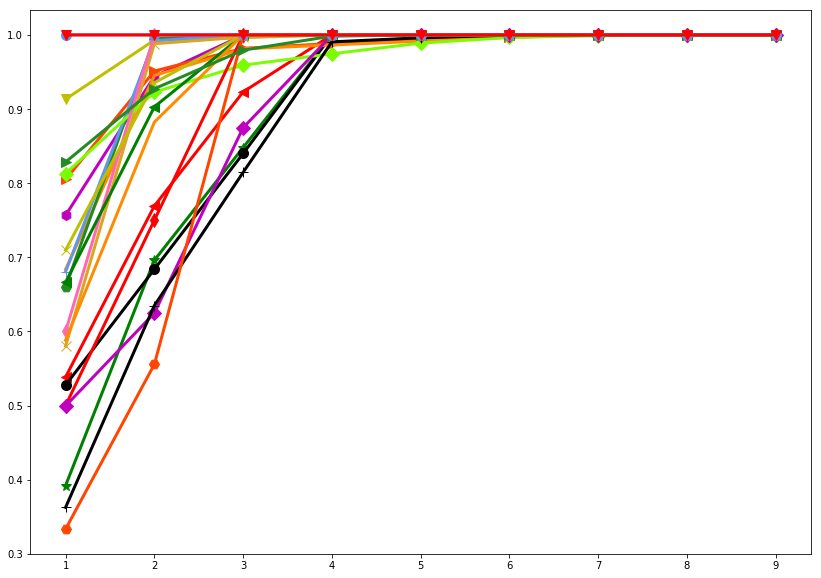

In [5]:
########## 归一化 ###############
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

for k, v in app_c_lines.items():
    print(k, v)
plt.figure(0)

colors = ['r','g','m', 'y','k','orangered','darkorange', 'forestgreen', 'cornflowerblue', 
          'goldenrod',  'lawngreen', 'hotpink','r','g','m', 'y','k','orangered','darkorange', 'forestgreen', 'cornflowerblue',
         'r','g','y','m', 'k','darkorange', 'orangered','forestgreen', 'cornflowerblue',]
marks = ['<','*','h','v','o','>',',','H','+','x','D','d', 
         'd', '<', 'D', 'x', '+', 'H', ',', '>', 'o', 'v', 'h', '*',
        '<','*','h','v','o','>',',','H','+','x','D','d', ]
plt.rcParams['figure.figsize'] = (14.0, 10.0) # 设置figure_size尺寸

top_task_precent = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

#top_task_precent = [0.2]
for i, k in enumerate(paths_data):
    y = []
    #if i == 5: break
    print('progressing -------------- ', i, k, app_c_lines[k])
    for precent in top_task_precent:                  
        temp_toptask_num = int(round(app_c_lines[k]*precent, 0))
        retval = most_tasks(paths_data[k], temp_toptask_num)
        y.append(sum(map(lambda e: e[2], retval[0])))

    plt.plot(list(range(1, len(y) + 1)), y, marker=marks[i], linestyle='-', color=colors[i], lw=3.0, ms=10, label=k)

        
plt.legend(loc = 'best')
plt.title("{} TinyOS Apps in Official Repository".format(len(app_c_lines.items()))) 
plt.ylim(0, 1)
plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [str(i*10.0)+'%' for i in range(1, 10)])
plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [str(i*100)+'%' for i in top_task_precent])

# app_xticks = []
# for k, v in app_c_lines.items():
#     if '/test/' in k: app_xticks.append(k[k.index('tests/')+len('tests/'):]) # tests目录下的app, 名字不包含tests
#     else: app_xticks.append(k[k.index('preprocessed-dataset/')+len('preprocessed-dataset/'):])

plt.xticks(list(range(1, len(top_task_precent) + 1)), [str(i*100)+'%' for i in top_task_precent])
plt.setp(plt.gca().get_xticklabels(), rotation=-25, horizontalalignment='left')
plt.savefig('feature-by-frequency-2d.png')
plt.show()  
plt.close(0)    

In [ ]:
###################### 2d ######################################
plt.figure(0)
top_task_num = 3
y = []
idx = 1 #
for k, v in paths_data.items():
    retval = most_tasks(v, top_task_num)
    print(retval, k)
    for e in map(lambda e: e[2], retval[0]):
        plt.plot([idx], [e], marker='o', color='r')
    idx += 1
    y.append(sum(map(lambda e: e[2], retval[0])))
plt.ylim(0, 1)
plt.plot(list(range(1, len(y) + 1)), y, marker='o', linestyle=' ')

plt.savefig('feature-by-frequency-2d.png')
plt.show()  
plt.close(0)
############ end of 2d ###########

In [ ]:

###################### 3d ######################################
colors = ['darkorange', 'forestgreen', 'cornflowerblue', 'goldenrod', 'lightseagreen', 'blueviolet', 'red',
         'y', 'teal', 'fuchsia', 'orangered', 'lawngreen', 'hotpink']

prob = [[] for i in range(top_task_num)]
app_name = [] # to set x ticks label
for k, v in paths_data.items():
    retval = most_tasks(v, top_task_num)
    if '/tests/' in k:
        app_name.append(k[k.index('tests/')+len('tests/'):]) # tests目录下的app, 名字不包含tests
    else:
        app_name.append(k[k.index('preprocessed-dataset/')+len('preprocessed-dataset/'):])
    #temp = list(map(lambda e: e[2], retval[0]))
    for i in range(top_task_num):
        if i >= len(retval[0]):
            prob[i].append(0.0)
        else:
            prob[i].append(retval[0][i][2])
plus_prob = []    

# Add up all the values.
for i in range(len(prob[0])):
    plus_prob.append(sum(map(lambda e: e[i], prob)))
prob.insert(0, plus_prob)

fig = plt.figure(1)
ax = fig.gca(projection='3d')
idx = 0
for c, z in zip(['k'] + [colors[i] for i in range(top_task_num)], reversed([i * 10 for i in range(top_task_num + 1)])):
    xs = np.arange(len(prob[0]))
    ys = prob[idx]
    idx += 1
    # You can provide either a single color or an array. To demonstrate this,
    # the first bar of each set will be colored cyan.
    cs = [c] * len(xs)
    ax.bar(xs, ys, zs=z, zdir='y', color=cs, alpha=0.8)
    
plt.rcParams['figure.figsize'] = (25.0, 18.0) # 设置figure_size尺寸
plt.rcParams['image.interpolation'] = 'nearest' # 设置 interpolation style   

ax.set_title("TinyOS APPs")
ax.set_xscale('linear')
#ax.grid(False) 去掉网格
#ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
# TODO: app_name 是每个应用的名称，但是不能正确设置到坐标轴上
#ax.set_xticklabels(app_name)


ax.set_yticklabels(['Top {}'.format(top_task_num-i) for i in range(top_task_num)] + ['Total'])
ax.set_zticklabels(['{}%'.format(i*20) for i in range(6)])
ax.set_xlabel('{} applications'.format(len(prob[0])))
ax.set_ylabel('{} top tasks'.format(top_task_num))
ax.set_zlabel('Percent')
plt.savefig('feature-by-frequency-3d.png')
plt.show()
plt.close(1)
############ end of 3d ###########

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

plt.figure(0)
fig = plt.figure(1)
ax = fig.gca(projection='3d')
help(ax.grid)